# 4장 - 유용한 선형회귀
 
 
## 4.1 선형회귀의 필요성
* 회귀분석은 인과추론의 핵심이자 가장 많이 사용되는 방법론
* 대부분의 패널데이터 방법론, 머신러닝 방법, 도구변수의 활용, 불연속 설계 등 응용 방법론의 주요 구성 요소
 
### 4.1.1 모델이 필요한 이유
* 은행에서 대출 금액이나 신용카드 한도가 채무불이행률에 미치는 영향을 알아보는 예제
    * 실제 데이터에서는 신용한도와 채무불이행률 사이에 음의 상관관계가 있음
    * 이는 은행과 대출 회사에서 심사 모델에 따라 채무불이행 가능성이 낮은 고객에게 더 높은 신용 한도를 설정하기 때문이다. -> 교란편향으로 인한 음의 상관관계 발생
* 앞서 봤던 조건부 독립성 가정이 만족되면 인과효과를 식별할 수 있겠지만, 조건부를 설정할 변수가 연속형이거나 변수의 수가 많을수록 차원의 저주에 걸릴 수 있다.
* 이를 해결하기 위해 잠재적 결과를 선형회귀 같은 방식으로 모델링할 수 있다 가정하고, X로 정의된 각각의 셀을 내삽+외삽 하는 것이다.


In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import graphviz as gr
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
style.use("ggplot")
import statsmodels.formula.api as smf
import matplotlib
from cycler import cycler

default_cycler = (cycler(color=['0.3', '0.5', '0.7', '0.5']))

color=['0.3', '0.5', '0.7', '0.9']
linestyle=['-', '--', ':', '-.']
marker=['o', 'v', 'd', 'p']

plt.rc('axes', prop_cycle=default_cycler)

gr.set_default_format("png");

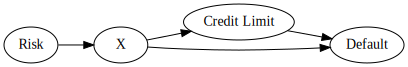

In [5]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Risk", "X")
g_risk.edge("X", "Credit Limit")
g_risk.edge("X", "Default")
g_risk.edge("Credit Limit", "Default")

g_risk

### 4.1.2 A/B 테스트와 회귀분석
* 온라인 스트리밍 기업에서 추천 시스템을 개선하는 상황을 가정해보자
    * 새로운 추천 시스템이 스트리밍 서비스의 시청 시간을 늘릴 수 있는지를 시험해보고자 할 때 관련된 수집 데이터는 아래와 같다.
* A/B 테스트 결과를 회귀분석으로 해석하면 필요한 추론 통계량 (표준오차, 신뢰구간)을 바로 구할 수 있다.
* 아래 예제의 회귀 모형은 아래와 같다.
    * $WahtchTime_i = \beta_0 + \beta_{1}challenger_{i}+e_i$
    * 새로운 버전의 효과는 $\beta_{1}$의 추정값인 $\hat{\beta_{1}}$ 이 된다.

In [6]:
import pandas as pd
import numpy as np

data = pd.read_csv("./data/rec_ab_test.csv")
data.head()

,recommender,age,tenure,watch_time
0,challenger,15,1,2.39
1,challenger,27,1,2.32
2,benchmark,17,0,2.74
3,benchmark,34,1,1.92
4,benchmark,14,1,2.47


In [7]:
import statsmodels.formula.api as smf

result = smf.ols('watch_time ~ C(recommender)', data=data).fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0491,0.058,35.367,0.000,1.935,2.163
C(recommender)[T.challenger],0.1427,0.095,1.501,0.134,-0.044,0.330


* 기존 버전의 추천 시스템을 사용했을 경우 절편항에 해당하는 2.04 시간 평균적으로 스트리밍을 이용한다고 할 수 있다.
* 0.14 가 새로운 버전 사용에 따른 시청 시간 증가 효과라 할 수 있다. 하지만 이는 통계적으로 유의하지 않다.

In [8]:
(data
 .groupby("recommender")
 ["watch_time"]
 .mean())

recommender
benchmark     2.049064
challenger    2.191750
Name: watch_time, dtype: float64

### 4.1.3 회귀분석을 통한 보정
* 다시 신용 한도와 채무불이행률 간의 관계를 회귀 모형으로 적용할 때 회귀 계수로 얻어진 값은 신용한도가 1달러 증가했을 때 채무불이행률이 얼마나 변할 것인지에 대한 기댓값을 나타낸다.
* 교란 변수를 처리하기 위해서는 회귀분석 모형에 단순히 교란요인들을 추가만 하면 된다. (OLS 추정)
    * $Default_i = \beta_0 + \beta_{1}line_{i} + \theta_{}X_{i}+ e_i$
    * $\beta_1$은 신용 한도에 대한 채무불이행률 기댓값의 편도함수라고 볼 수 있다.
    * 직관적으로 모델의 다른 변수들이 고정된 상태에서 신용 한도를 조금 늘렸을 때 채무불이행률이 얼마나 변할지에 대한 기댓값이다.

In [9]:
risk_data = pd.read_csv("./data/risk_data.csv")

risk_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,default
0,950.0,11,16,1,500.0,518.0,3200.0,0
1,780.0,11,7,1,414.0,429.0,1700.0,0
2,1230.0,14,9,1,586.0,571.0,4200.0,0
3,1040.0,15,8,1,379.0,411.0,1500.0,0
4,1000.0,16,1,1,379.0,518.0,1800.0,0


In [10]:
model = smf.ols('default ~ credit_limit', data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2192,0.004,59.715,0.000,0.212,0.226
credit_limit,-2.402e-05,1.16e-06,-20.689,0.000,-2.63e-05,-2.17e-05


Text(0.5, 1.0, 'Default Rate by Credit Limit')

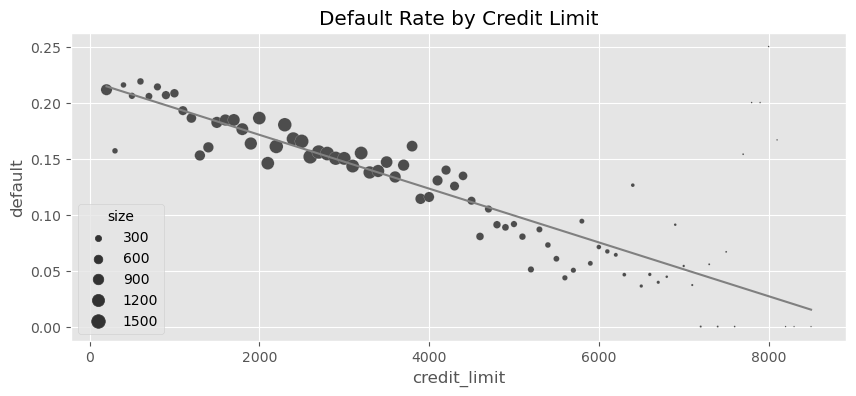

In [11]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default": "mean", "size":sum})
          .reset_index()
          .assign(prediction = lambda d: model.predict(d)))

plt.figure(figsize=(10,4))

sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))

plt.plot(plt_df["credit_limit"], plt_df["prediction"], color="C1")
plt.title("Default Rate by Credit Limit")


In [12]:
risk_data.groupby(["credit_score1", "credit_score2"]).size().head()

credit_score1  credit_score2
34.0           339.0            1
               500.0            1
52.0           518.0            1
69.0           214.0            1
               357.0            1
dtype: int64

In [13]:
formula = 'default ~ credit_limit + wage+credit_score1+credit_score2'
model = smf.ols(formula, data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


* 프리슈 워 로벨 정리 (FWL) 를 통해 편향 제거 단계와 영향 추정 단계를 분리할 수 있다. 

## 4.2 회귀분석 이론
* 매개변수 벡터를 $\beta^{*}$ 라 할 때 아래와 같이 정의할 수 있다.
    * $\beta^{*} = \underset{\beta}{argmin}E[{(Y_i - X_i^{`}\beta)}^2]$
* 선형회귀분석은 평균제곱오차를 최소화하는 매개변수를 찾는다. 이를 미분하고 그 결과를 0 으로 두면 선형 해는 아래와 같다.
    * $\beta^{*} = E{[X^{`}X]}^{-1}E[X^{`}Y]$

In [14]:
X_cols = ["credit_limit", "wage", "credit_score1", "credit_score2"]
X = risk_data[X_cols].assign(intercep=1)
y = risk_data["default"]

def regress(y, X): 
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

beta = regress(y, X)
beta

array([ 3.06252773e-06, -8.82159125e-05, -4.17472814e-05, -3.03928359e-04,
        4.03661277e-01])

### 4.2.1 단순선형회귀
* 인과추론에서는 변수 T가 결과 Y에 미치는 인과효과를 추정하려는 경우가 많다.
* 단일 설명변수 T를 사용할 때 관련된 매개변수는 아래와 같다.
    * $\hat{\tau} = \frac{Cov(Y_i, T_i)}{Var(T_i)} = \frac{E[(T_i-\bar{T})(Y_i - \bar{Y})]}{E[(T_i - \bar{T})^2]}$
* 회귀분석은 처치와 결과가 어떻게 함꼐 움직이는지(분자의 공분산) 를 파악하고 이를 처치 대상에 따라 조정한다.

### 4.2.2 다중선형회귀
* 다중선형회귀의 경우 단순선형회귀분석을 확장하기만 하면 된다. 다른 변수는 보조적인 변수들이고 T와 관련된 $\tau$ 를 추정하는 것으로 생각하면 아래와 같이 정리할 수 있다.
    * $\hat{\tau} = \frac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})}$
    * $\tilde{T_i}$ 는 $T_i$ 를 모든 공변량 $X_{1i} + ...  + X_{ki}$ 에 대해 회귀한 잔차이다.
    * 다시 말해, 다중회귀분석의 회귀계수는 모델의 다른 변수들의 효과를 고려한 후 얻은 동일 설명변수의 이변량 계수라는 의미이다.
* 직관적으로 보면, 다른 변수를 사용해 T를 예측할 수 있다면 T는 무작위가 아니다. 그러나 모든 교란 요인 X를 통제하면 T를 무작위로 보이게 할 수 있다.
    * 이를 위해 선형회구분석을 사용해 교란 요인에서 T를 예측한 다음, T에서 해당 회귀에 대한 잔차인 $\tilde{T}$ 를 뺴주면 된다.

## 4.3 프리슈-워-로벨 정리와 직교화
* FWL 스타일의 직교화는 가장 먼저 사용할 수 있는 편향 제거(debiasing) 기법이다.
* FWL 정리에 따르면 다중선형회귀분석은 한 번에 추정하거나 세 단계에 걸쳐 추정할 수 있다.
* 먼저 아래처럼 Y~T,X1,X2,... 로 회귀할 수 있다.
* FWL 정리에 따라 추정 과정을 다음과 같이 세 단계로 나눌 수 있다.
    1. 편향 제거 단계 : 처치 T를 교란 요인 X에 회귀해 처지 잔차를 구한다.
    2. 잡음 제거 단계 : 결과 Y를 교란 요인 X에 회귀해 결과 잔차를 구한다.
    3. 결과 모델 단계 : 결과 잔차를 처치 잔차에 대해 회귀해 T가 Y에 미치는 인과효과 추정값은 구한다.

In [15]:
formula = 'default ~ credit_limit + wage+credit_score1+credit_score2'
model = smf.ols(formula, data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


### 4.3.1 편향 제거 단계
* FWL 정리에 따르면, 교란 요인으로부터 처치인 신용 한도를 예측하는 회귀 모델을 적합시켜 데이터의 편향을 제거할 수 있다. 이 때 구해진 잔차는 편향 제거 모델에 사용된 변수와는 상관관계가 없는 버전의 처치로 간주할 수 있다. (예측값을 새성한 변수와 직교하기 때문)

Text(0.5, 1.0, 'Default Rate by Credit Limit')

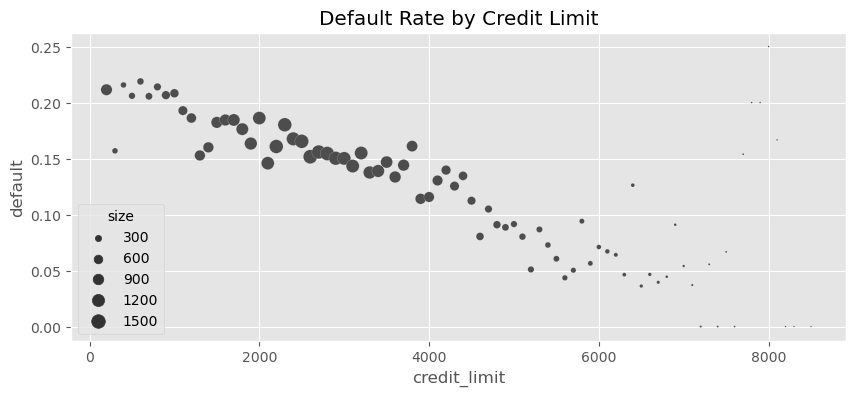

In [16]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default": "mean", "size":sum})
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))


plt.title("Default Rate by Credit Limit")


In [17]:
debiasing_model = smf.ols(
    'credit_limit ~ wage + credit_score1  + credit_score2',
    data=risk_data
).fit()

risk_data_deb = risk_data.assign(
    # for visualization, avg(T) is added to the residuals
    credit_limit_res=(debiasing_model.resid 
                      + risk_data["credit_limit"].mean())
)

In [18]:
model_w_deb_data = smf.ols('default ~ credit_limit_res',
                           data=risk_data_deb).fit()

model_w_deb_data.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.001,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.56e-06,1.957,0.050,-4.29e-09,6.13e-06


* full model 과 차이가 있다면 p값이 약간 높다는 점이다. 이는 분산 감소를 담당하는 잡음 제거 단계를 거치지 않았기 때문이다. 잔차와 결과 변수 간의 관계를 시각화 하면 아래와 같다.

Text(0.5, 1.0, 'Default Rate by Debiased Credit Limit')

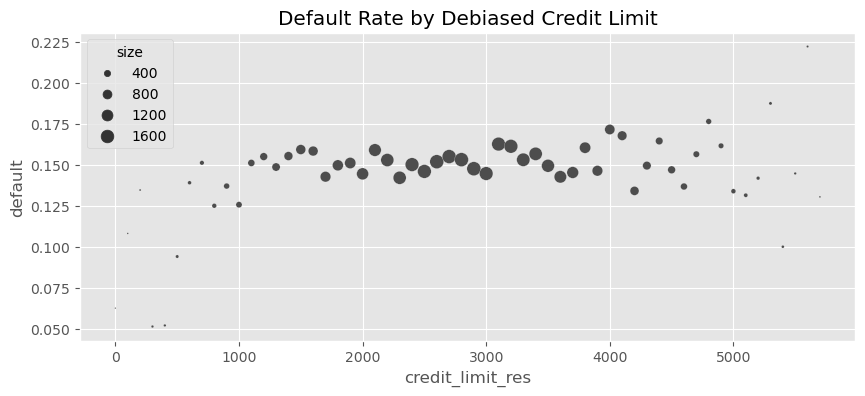

In [19]:
plt_df = (risk_data_deb
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2))
          .groupby("credit_limit_res")
          .agg({"default": "mean", "size":sum})
          .query("size>30")
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default",
                size="size",
                sizes=(1,100))

plt.title("Default Rate by Debiased Credit Limit")


### 4.3.2 잡음 제거 단계
* 잡음을 제거한다고 처치 효과의 추정값이 바뀌지는 않지만 분산을 줄일 수 있는 효과를 가진다.
* 이 단계에서는 결과를 처치가 아닌 공변량 X에 대해 회귀한다.

In [20]:
denoising_model = smf.ols(
    'default ~ wage + credit_score1  + credit_score2',
    data=risk_data_deb
).fit()

risk_data_denoise = risk_data_deb.assign(
    default_res=denoising_model.resid + risk_data_deb["default"].mean()
)

### 4.3.3 회귀 추정량의 표준오차
* 추정한 회귀계수의 표준오차 공식은 아래와 같다.
    * $SE(\hat{\beta}) = \frac{\sigma(\hat{\epsilon})}{\sigma(\tilde{T})\sqrt{n-DF}}$
* 분자는 결과를 잘 예측할수록 잔차가 작아지므로 추정값의 분산이 낮아진다.
    * 처치가 결과를 많이 설명하면 추정값의 표준오차도 작아진다.
* 오차는 (잔차화된) 처치의 분산에 반비례한다. 

In [22]:
model_se = smf.ols(
    'default ~ wage + credit_score1  + credit_score2',
    data=risk_data
).fit()

print("SE regression:", model_se.bse["wage"])


model_wage_aux = smf.ols(
    'wage ~ credit_score1 + credit_score2',
    data=risk_data
).fit()

# subtract the degrees of freedom - 4 model parameters - from N.
se_formula = (np.std(model_se.resid)
              /(np.std(model_wage_aux.resid)*np.sqrt(len(risk_data)-4)))

print("SE formula:   ", se_formula)

SE regression: 5.364242347548209e-06
SE formula:    5.364242347548201e-06


### 4.3.4 최종 결과 모델
* 마지막으로 두 잔차를 이용해 회귀를 진행하면 full model 에서 얻었던 결과와 동일한 결과를 얻게 된다.

In [24]:
model_w_orthogonal = smf.ols('default_res ~ credit_limit_res',
                             data=risk_data_denoise).fit()

model_w_orthogonal.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.458,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.54e-06,1.987,0.047,4.17e-08,6.08e-06


Text(0.5, 1.0, 'Denoised Default Rate by Debiased Credit Limit')

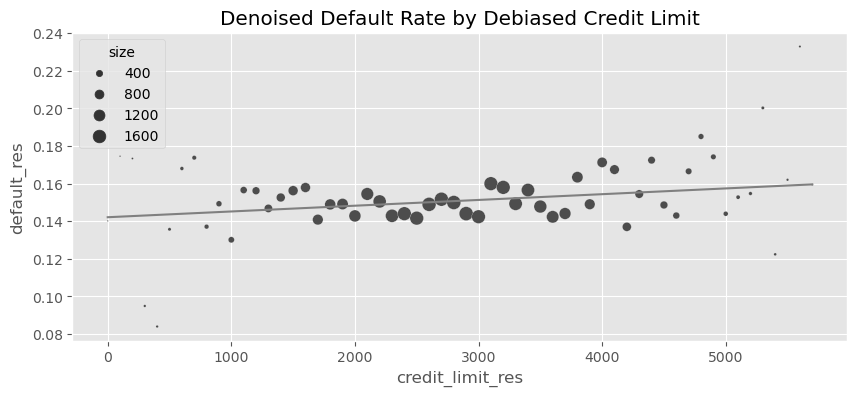

In [25]:
plt_df = (risk_data_denoise
          .assign(size=1)
          .assign(credit_limit_res = lambda d: d["credit_limit_res"].round(-2))
          .groupby("credit_limit_res")
          .agg({"default_res": "mean", "size":sum})
          .query("size>30")
          .reset_index()
          .assign(prediction = lambda d: model_w_orthogonal.predict(d)))

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default_res",
                size="size",
                sizes=(1,100))

plt.plot(plt_df["credit_limit_res"], plt_df["prediction"], c="C1")

plt.title("Denoised Default Rate by Debiased Credit Limit")



### 4.3.5 FWL 정리 요약

## 4.4 결과 모델으로서의 회귀분석
* 회귀분석은 잠재적 결과를 대체하는 방법으로도 볼 수 있다.
* 대조군 (T=0) 에서 X에 대한 Y의 회귀 분석이 $E[Y_0|X]$를 아주 잘 근사한다면, 해당 모델을 이용해 ATT를 추정할 수 있다.
    * $ATTT = \frac{1}{N}\sum{I(T_i=1)(Y_i- \hat{\mu_0}(X_i))}$
* 동일하게 실험군에서도 X에 대한 Y의 회귀분석이 잘 모델링된다면, 대조군에서의 평균 효과를 추정할 수 있다.
    * $ATE = \frac{1}{N}\sum{\hat{\mu_1}(X_i) - \hat{mu_0}(X_i)}$
* $E[T|X]$를 정확하게 추정하여 직교화할 수 있거나 잠재적 결과 $E[Y_t|X]$를 정확하게 추정할 수 있다느 사실은 회귀분석이 이중 강건하다는 특성을 나타낸다.

## 4.5 양수성과 외삽
- 회귀분석은 잠재적 결과를 모수적으로 모델링하므로 데이터의 처치 범위 외의 범위에 대해서도 외삽을 할 수 있다.

Text(0.5, 1.0, 'Dataset 2')

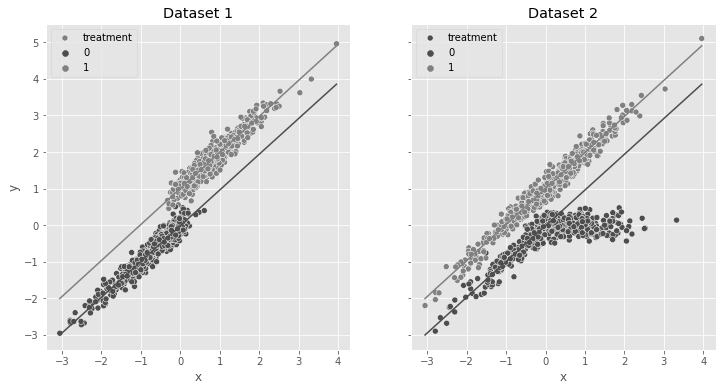

In [21]:
np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.normal(x, 0.2, n) > 0

y0 = x 
y1 = 1 + x

y = np.random.normal((1-t)*y0 + t*y1, 0.2)

df_no_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.scatterplot(data=df_no_pos, x="x", y="y", hue="t", ax=ax1, label="treatment")

m0 = smf.ols("y~x", data=df_no_pos.query(f"t==0")).fit()
m1 = smf.ols("y~x", data=df_no_pos.query(f"t==1")).fit()

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_no_pos)), x="x", y="pred", color=f"C0", ax=ax1)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_no_pos)), x="x", y="pred", color=f"C1", ax=ax1);
ax1.set_title("Dataset 1")

np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.binomial(1, 0.5, size=n)

y0 = x * (x<0) + (x>0)*0
y1 = 1 + x

y = np.random.normal((1-t)*y0 + t*y1, 0.2)

df_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

sns.scatterplot(data=df_pos, x="x", hue="t", y="y", ax=ax2, label="treatment")

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_pos)), x="x", y="pred", color=f"C0", ax=ax2)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_pos)), x="x", y="pred", color=f"C1", ax=ax2)
ax2.set_title("Dataset 2")



## 4.6 선형회귀에서의 비선형성


In [22]:
spend_data = pd.read_csv("./data/spend_data.csv")

spend_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,spend
0,950.0,11,16,1,500.0,518.0,3200.0,3848
1,780.0,11,7,1,414.0,429.0,1700.0,3144
2,1230.0,14,9,1,586.0,571.0,4200.0,4486
3,1040.0,15,8,1,379.0,411.0,1500.0,3327
4,1000.0,16,1,1,379.0,518.0,1800.0,3508


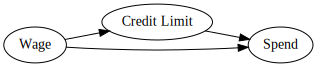

In [23]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Wage", "Credit Limit")
g_risk.edge("Wage", "Spend")
g_risk.edge("Credit Limit", "Spend")

g_risk

<AxesSubplot:xlabel='credit_limit', ylabel='spend'>

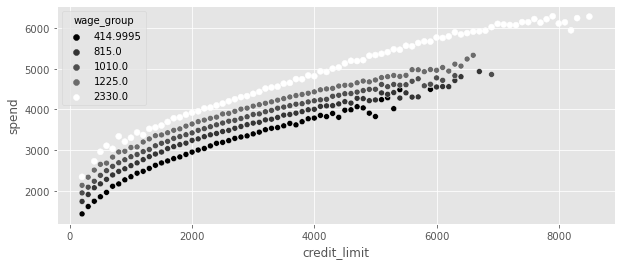

In [24]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                hue="wage_group",
                palette="gray")


### 4.6.1 처치 선형화

<AxesSubplot:xlabel='credit_limit_sqrt', ylabel='spend'>

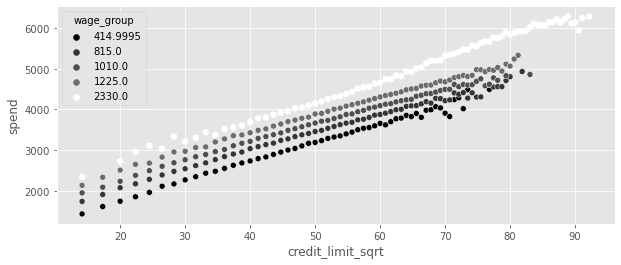

In [25]:
plt_df = (spend_data
          # apply the sqrt function to the treatment
          .assign(credit_limit_sqrt = np.sqrt(spend_data["credit_limit"]))
          # create 5 wage binds for better vizualization
          .assign(wage_group = pd.IntervalIndex(pd.qcut(spend_data["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit_sqrt"])
          [["spend"]]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df, 
                x="credit_limit_sqrt",
                y="spend",
                palette="gray",
                hue="wage_group")


In [26]:
model_spend = smf.ols(
    'spend ~ np.sqrt(credit_limit)',data=spend_data
).fit()

model_spend.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,493.0044,6.501,75.832,0.000,480.262,505.747
np.sqrt(credit_limit),63.2525,0.122,519.268,0.000,63.014,63.491


<AxesSubplot:xlabel='credit_limit', ylabel='spend'>

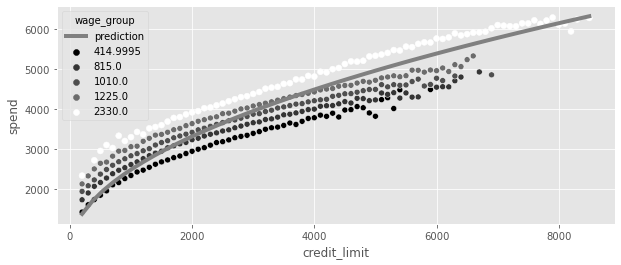

In [27]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index()
         )

x = np.linspace(plt_df["credit_limit"].min(), plt_df["credit_limit"].max())

plt.figure(figsize=(10,4))
plt.plot(x, model_spend.params[0] + model_spend.params[1]*np.sqrt(x), color="C1", label="prediction", lw=4)
plt.legend()
sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                palette="gray",
                hue="wage_group")



In [28]:
model_spend = smf.ols('spend ~ np.sqrt(credit_limit)+wage',
                      data=spend_data).fit()

model_spend.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,383.5002,2.746,139.662,0.000,378.118,388.882
np.sqrt(credit_limit),43.8504,0.065,672.633,0.000,43.723,43.978
wage,1.0459,0.002,481.875,0.000,1.042,1.050


### 4.6.2 비선형 FWL과 편향 제거


In [29]:
debias_spend_model = smf.ols(f'np.sqrt(credit_limit) ~ wage',
                             data=spend_data).fit()
denoise_spend_model = smf.ols(f'spend ~ wage', data=spend_data).fit()


credit_limit_sqrt_deb = (debias_spend_model.resid 
                         + np.sqrt(spend_data["credit_limit"]).mean())
spend_den = denoise_spend_model.resid + spend_data["spend"].mean()


spend_data_deb = (spend_data
                  .assign(credit_limit_sqrt_deb = credit_limit_sqrt_deb,
                          spend_den = spend_den))

final_model = smf.ols(f'spend_den ~ credit_limit_sqrt_deb',
                      data=spend_data_deb).fit()

final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1493.6990,3.435,434.818,0.000,1486.966,1500.432
credit_limit_sqrt_deb,43.8504,0.065,672.640,0.000,43.723,43.978


<AxesSubplot:xlabel='credit_limit', ylabel='spend'>

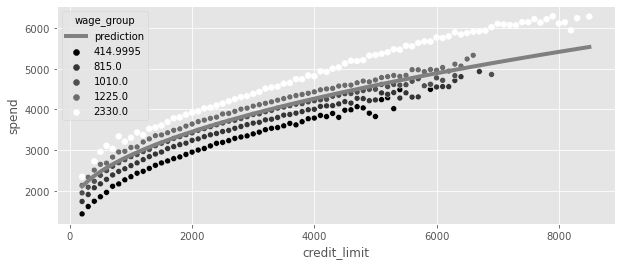

In [30]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"], 5)).mid)
          .groupby(["wage_group", "credit_limit"])
          [["spend"]]
          .mean()
          .reset_index())

x = np.linspace(plt_df["credit_limit"].min(), plt_df["credit_limit"].max())

plt.figure(figsize=(10,4))
plt.plot(x, (final_model.params[0] 
             + final_model.params[1]*np.sqrt(x)),
         color="C1", label="prediction", lw=4)

plt.legend()

sns.scatterplot(data=plt_df, 
                x="credit_limit",
                y="spend",
                palette="gray",
                hue="wage_group")


## 4.7 더미변수를 활용한 회귀분석
 
### 4.7.1 조건부 무작위 실험


In [31]:
risk_data_rnd = pd.read_csv("./data/risk_data_rnd.csv")
risk_data_rnd.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_score1_buckets,credit_limit,default
0,890.0,11,16,1,490.0,500.0,400,5400.0,0
1,670.0,11,7,1,196.0,481.0,200,3800.0,0
2,1220.0,14,9,1,392.0,611.0,400,5800.0,0
3,1210.0,15,8,1,627.0,519.0,600,6500.0,0
4,900.0,16,1,1,275.0,519.0,200,2100.0,0


Text(0.5, 1.0, 'Conditional random experiment')

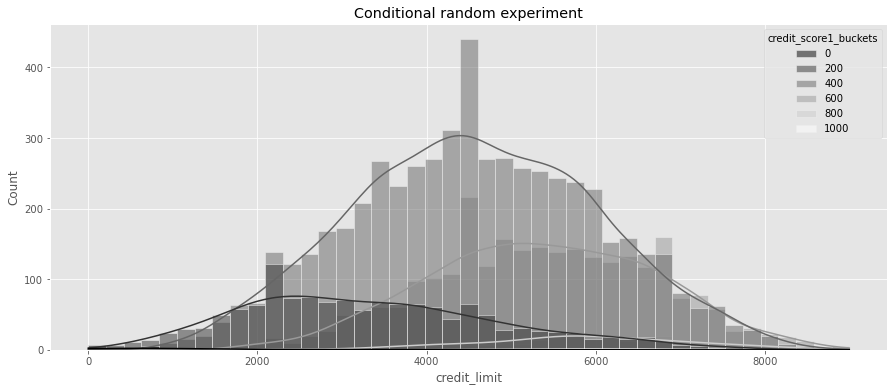

In [32]:
plt.figure(figsize=(15,6))
sns.histplot(data=risk_data_rnd,
             x="credit_limit",
             hue="credit_score1_buckets",
             kde=True,
             palette="gray");
plt.title("Conditional random experiment")

### 4.7.2 더미변수
 


In [33]:
model = smf.ols("default ~ credit_limit", data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1369,0.009,15.081,0.000,0.119,0.155
credit_limit,-9.344e-06,1.85e-06,-5.048,0.000,-1.3e-05,-5.72e-06


In [34]:
pd.set_option('display.max_columns', 9)

In [35]:
risk_data_dummies = (risk_data_rnd
                     .join(pd.get_dummies(risk_data_rnd["credit_score1_buckets"],
                                          prefix="sb",
                                          drop_first=True)))
risk_data_dummies.head()

,wage,educ,exper,married,...,sb_400,sb_600,sb_800,sb_1000
0,890.0,11,16,1,...,1,0,0,0
1,670.0,11,7,1,...,0,0,0,0
2,1220.0,14,9,1,...,1,0,0,0
3,1210.0,15,8,1,...,0,1,0,0
4,900.0,16,1,1,...,0,0,0,0


In [36]:
model = smf.ols(
    "default ~ credit_limit + sb_200+sb_400+sb_600+sb_800+sb_1000",
    data=risk_data_dummies
).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06
sb_200,-0.0559,0.057,-0.981,0.327,-0.168,0.056
sb_400,-0.1442,0.057,-2.538,0.011,-0.256,-0.033
sb_600,-0.2148,0.057,-3.756,0.000,-0.327,-0.103
sb_800,-0.2489,0.060,-4.181,0.000,-0.366,-0.132
sb_1000,-0.2541,0.094,-2.715,0.007,-0.438,-0.071


In [37]:
model = smf.ols("default ~ credit_limit + C(credit_score1_buckets)",
                data=risk_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
C(credit_score1_buckets)[T.200],-0.0559,0.057,-0.981,0.327,-0.168,0.056
C(credit_score1_buckets)[T.400],-0.1442,0.057,-2.538,0.011,-0.256,-0.033
C(credit_score1_buckets)[T.600],-0.2148,0.057,-3.756,0.000,-0.327,-0.103
C(credit_score1_buckets)[T.800],-0.2489,0.060,-4.181,0.000,-0.366,-0.132
C(credit_score1_buckets)[T.1000],-0.2541,0.094,-2.715,0.007,-0.438,-0.071
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06


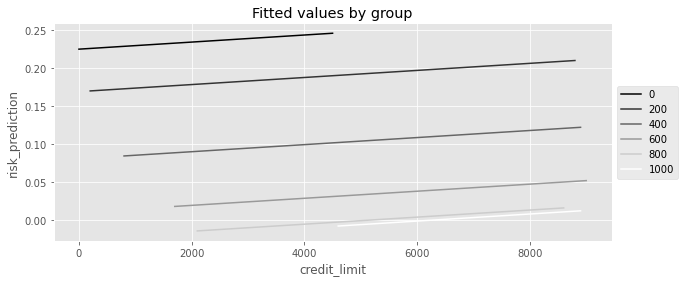

In [38]:
plt_df = (risk_data_rnd
          .assign(risk_prediction = model.fittedvalues)
          .groupby(["credit_limit", "credit_score1_buckets"])
          ["risk_prediction"]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.lineplot(data=plt_df,
             x="credit_limit", y="risk_prediction", hue="credit_score1_buckets", palette = 'gray');
plt.title("Fitted values by group")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


### 4.7.3 포화회귀모델


In [39]:
def regress(df, t, y):
    return smf.ols(f"{y}~{t}", data=df).fit().params[t]

effect_by_group = (risk_data_rnd
                   .groupby("credit_score1_buckets")
                   .apply(regress, y="default", t="credit_limit"))
effect_by_group

credit_score1_buckets
0      -0.000071
200     0.000007
400     0.000005
600     0.000003
800     0.000002
1000    0.000000
dtype: float64

In [40]:
group_size = risk_data_rnd.groupby("credit_score1_buckets").size()
ate = (effect_by_group * group_size).sum() / group_size.sum()
ate

4.490445628748722e-06

In [41]:
model = smf.ols("default ~ credit_limit * C(credit_score1_buckets)",
                data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3137,0.077,4.086,0.000,0.163,0.464
C(credit_score1_buckets)[T.200],-0.1521,0.079,-1.926,0.054,-0.307,0.003
C(credit_score1_buckets)[T.400],-0.2339,0.078,-3.005,0.003,-0.386,-0.081
C(credit_score1_buckets)[T.600],-0.2957,0.080,-3.690,0.000,-0.453,-0.139
C(credit_score1_buckets)[T.800],-0.3227,0.111,-2.919,0.004,-0.539,-0.106
C(credit_score1_buckets)[T.1000],-0.3137,0.428,-0.733,0.464,-1.153,0.525
credit_limit,-7.072e-05,4.45e-05,-1.588,0.112,-0.000,1.66e-05
credit_limit:C(credit_score1_buckets)[T.200],7.769e-05,4.48e-05,1.734,0.083,-1.01e-05,0.000
credit_limit:C(credit_score1_buckets)[T.400],7.565e-05,4.46e-05,1.696,0.090,-1.18e-05,0.000
credit_limit:C(credit_score1_buckets)[T.600],7.398e-05,4.47e-05,1.655,0.098,-1.37e-05,0.000


In [42]:
(model.params[model.params.index.str.contains("credit_limit:")]
 + model.params["credit_limit"]).round(9)

credit_limit:C(credit_score1_buckets)[T.200]     0.000007
credit_limit:C(credit_score1_buckets)[T.400]     0.000005
credit_limit:C(credit_score1_buckets)[T.600]     0.000003
credit_limit:C(credit_score1_buckets)[T.800]     0.000002
credit_limit:C(credit_score1_buckets)[T.1000]    0.000000
dtype: float64

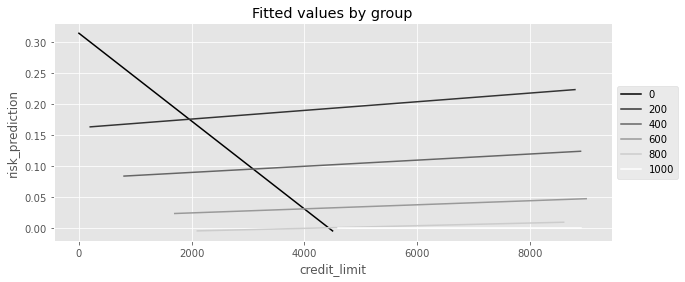

In [43]:
plt_df = (risk_data_rnd
          .assign(risk_prediction = model.fittedvalues)
          .groupby(["credit_limit", "credit_score1_buckets"])
          ["risk_prediction"]
          .mean()
          .reset_index())

plt.figure(figsize=(10,4))
sns.lineplot(data=plt_df,
             x="credit_limit", y="risk_prediction", hue="credit_score1_buckets",  palette="gray");
plt.title("Fitted values by group")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### 4.7.4 분산의 가중평균과 회귀분석


In [44]:
np.random.seed(123)

# std(t)=1
t1 = np.random.normal(0, 1, size=1000)
df1 = pd.DataFrame(dict(
    t=t1,
    y=1*t1, # ATE of 1
    g=1,
))

# std(t)=2
t2 = np.random.normal(0, 2, size=500)
df2 = pd.DataFrame(dict(
    t=t2,
    y=2*t2, # ATE of 2
    g=2,
))

df = pd.concat([df1, df2])
df.head()

,t,y,g
0,-1.085631,-1.085631,1
1,0.997345,0.997345,1
2,0.282978,0.282978,1
3,-1.506295,-1.506295,1
4,-0.578600,-0.578600,1


In [45]:
effect_by_group = df.groupby("g").apply(regress, y="y", t="t")
ate = (effect_by_group *
       df.groupby("g").size()).sum() / df.groupby("g").size().sum()
ate

1.333333333333333

In [46]:
model = smf.ols("y ~ t + C(g)", data=df).fit()
model.params

Intercept    0.024758
C(g)[T.2]    0.019860
t            1.625775
dtype: float64

### 4.7.5 평균 제거와 고정효과

In [47]:
model_deb = smf.ols("credit_limit ~ C(credit_score1_buckets)",
                    data=risk_data_rnd).fit()
model_deb.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1173.0769,278.994,4.205,0.000,626.193,1719.961
C(credit_score1_buckets)[T.200],2195.4337,281.554,7.798,0.000,1643.530,2747.337
C(credit_score1_buckets)[T.400],3402.3796,279.642,12.167,0.000,2854.224,3950.535
C(credit_score1_buckets)[T.600],4191.3235,280.345,14.951,0.000,3641.790,4740.857
C(credit_score1_buckets)[T.800],4639.5105,291.400,15.921,0.000,4068.309,5210.712
C(credit_score1_buckets)[T.1000],5006.9231,461.255,10.855,0.000,4102.771,5911.076


In [48]:
risk_data_rnd.groupby("credit_score1_buckets")["credit_limit"].mean()

credit_score1_buckets
0       1173.076923
200     3368.510638
400     4575.456498
600     5364.400448
800     5812.587413
1000    6180.000000
Name: credit_limit, dtype: float64

In [49]:
risk_data_fe = risk_data_rnd.assign(
    credit_limit_avg = lambda d: (d
                                  .groupby("credit_score1_buckets")
                                  ["credit_limit"].transform("mean"))
)

In [50]:
model = smf.ols("default ~ I(credit_limit-credit_limit_avg)",
                data=risk_data_fe).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0935,0.003,32.121,0.000,0.088,0.099
I(credit_limit - credit_limit_avg),4.652e-06,2.05e-06,2.273,0.023,6.4e-07,8.66e-06


In [51]:
model = smf.ols("default ~ credit_limit + credit_limit_avg",
                data=risk_data_fe).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4325,0.020,21.418,0.000,0.393,0.472
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.96e-07,8.61e-06
credit_limit_avg,-7.763e-05,4.75e-06,-16.334,0.000,-8.69e-05,-6.83e-05


## 4.8 누락 변수 편향


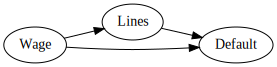

In [52]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})


g.edge("Lines", "Default")
g.edge("Wage", "Default"),
g.edge("Wage", "Lines")


g

In [53]:
short_model = smf.ols("default ~ credit_limit", data=risk_data).fit()
short_model.params["credit_limit"]

-2.401961992596885e-05

In [54]:
long_model = smf.ols("default ~ credit_limit + wage",
                     data=risk_data).fit()

omitted_model = smf.ols("wage ~ credit_limit", data=risk_data).fit()

(long_model.params["credit_limit"] 
 + long_model.params["wage"]*omitted_model.params["credit_limit"])

-2.4019619925968762e-05

## 4.9 중립 통제변수


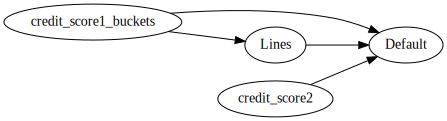

In [55]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})

g.edge("credit_score1_buckets", "Default"),
g.edge("credit_score1_buckets", "Lines"),
g.edge("credit_score2", "Default"),
g.edge("Lines", "Default")

g

In [56]:
formula = "default~credit_limit+C(credit_score1_buckets)+credit_score2"
model = smf.ols(formula, data=risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5576,0.055,10.132,0.000,0.450,0.665
C(credit_score1_buckets)[T.200],-0.0387,0.055,-0.710,0.478,-0.146,0.068
C(credit_score1_buckets)[T.400],-0.1032,0.054,-1.898,0.058,-0.210,0.003
C(credit_score1_buckets)[T.600],-0.1410,0.055,-2.574,0.010,-0.248,-0.034
C(credit_score1_buckets)[T.800],-0.1161,0.057,-2.031,0.042,-0.228,-0.004
C(credit_score1_buckets)[T.1000],-0.0430,0.090,-0.479,0.632,-0.219,0.133
credit_limit,4.928e-06,1.93e-06,2.551,0.011,1.14e-06,8.71e-06
credit_score2,-0.0007,2.34e-05,-30.225,0.000,-0.001,-0.001


### 4.9.1 잡음 유발 통제변수


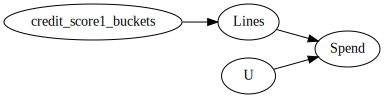

In [57]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})


g.edge("credit_score1_buckets", "Lines"),
g.edge("U", "Spend"),
g.edge("Lines", "Spend")

g

In [58]:
spend_data_rnd = pd.read_csv("data/spend_data_rnd.csv")

model = smf.ols("spend ~ np.sqrt(credit_limit)",
                data=spend_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2153.2154,218.600,9.850,0.000,1723.723,2582.708
np.sqrt(credit_limit),16.2915,2.988,5.452,0.000,10.420,22.163


In [59]:
model = smf.ols("spend~np.sqrt(credit_limit)+C(credit_score1_buckets)",
                data=spend_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2367.4867,556.273,4.256,0.000,1274.528,3460.446
C(credit_score1_buckets)[T.200],-144.7921,591.613,-0.245,0.807,-1307.185,1017.601
C(credit_score1_buckets)[T.400],-118.3923,565.364,-0.209,0.834,-1229.211,992.427
C(credit_score1_buckets)[T.600],-111.5738,570.471,-0.196,0.845,-1232.429,1009.281
C(credit_score1_buckets)[T.800],-89.7366,574.645,-0.156,0.876,-1218.791,1039.318
C(credit_score1_buckets)[T.1000],363.8990,608.014,0.599,0.550,-830.720,1558.518
np.sqrt(credit_limit),14.5953,3.523,4.142,0.000,7.673,21.518


### 4.9.2 특성 선택: 편향-분산 트레이드오프


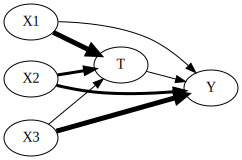

In [60]:
g = gr.Digraph(graph_attr={"rankdir": "LR"})


g.edge("X1", "T", penwidth="5"),
g.edge("X2", "T", penwidth="3"),
g.edge("X3", "T", penwidth="1"),

g.edge("X1", "Y", penwidth="1"),
g.edge("X2", "Y", penwidth="3"),
g.edge("X3", "Y", penwidth="5"),

g.edge("T", "Y"),

g

In [61]:
np.random.seed(123)

n = 100
(x1, x2, x3) = (np.random.normal(0, 1, n) for _ in range(3))
t = np.random.normal(10*x1 + 5*x2 + x3)

# ate = 0.05
y = np.random.normal(0.05*t + x1 + 5*x2 + 10*x3, 5)
df = pd.DataFrame(dict(y=y, t=t, x1=x1, x2=x2, x3=x3))

smf.ols("y~t+x1+x2+x3", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2707,0.527,0.514,0.608,-0.775,1.316
t,0.8664,0.607,1.427,0.157,-0.339,2.072
x1,-7.0628,6.038,-1.170,0.245,-19.049,4.923
x2,0.0143,3.128,0.005,0.996,-6.195,6.224
x3,9.6292,0.887,10.861,0.000,7.869,11.389


In [62]:
smf.ols("y~t+x2+x3", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1889,0.523,0.361,0.719,-0.849,1.227
t,0.1585,0.046,3.410,0.001,0.066,0.251
x2,3.6095,0.582,6.197,0.000,2.453,4.766
x3,10.4549,0.537,19.453,0.000,9.388,11.522


## 4.10 요약


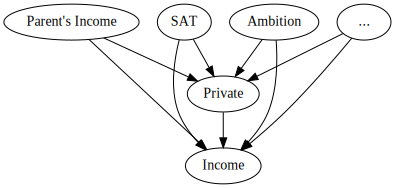

In [63]:
import graphviz as gr

g = gr.Digraph(format="png")

g.edge("Parent's Income", "Private")
g.edge("SAT", "Private")
g.edge("Ambition", "Private")
g.edge("...", "Private")

g.edge("Parent's Income", "Income")
g.edge("SAT", "Income")
g.edge("Ambition", "Income")
g.edge("...", "Income")

g.edge("Private", "Income")

g